Install and import required packages and libraries

In [21]:
# Install libraries if needed
!pip install gym
!apt-get install wget

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import gym
from gym import spaces
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Dataset Download & Preprocessing

In [ ]:
# Download Train Dataset
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt

# Column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# Load train data
train_data = pd.read_csv('KDDTrain+.txt', names=columns)
train_data.drop('difficulty', axis=1, inplace=True)

# Encode categorical columns
for col in ['protocol_type', 'service', 'flag']:
    train_data[col] = LabelEncoder().fit_transform(train_data[col])

# Separate features and labels
X = train_data.drop('label', axis=1)
y = train_data['label']

# Binarize labels
y = y.apply(lambda x: 0 if x == 'normal' else 1)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reduce dataset for faster training
sample_fraction = 1  # use 100% of data
X = X[:int(sample_fraction * len(X))]
y = y[:int(sample_fraction * len(y))]

print(f"Training Data: {X.shape}, {y.shape}")


--2025-05-05 02:33:45--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt.2’

KDDTrain+.txt.2     100%[===================>]  18.22M  --.-KB/s    in 0.1s    

2025-05-05 02:33:46 (130 MB/s) - ‘KDDTrain+.txt.2’ saved [19109424/19109424]

Training Data: (125973, 41), (125973,)


Save the scaler pickle

In [ ]:
# Save the trained scaler for consistent data normalization during inference

import joblib

# Save it
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

Setup Custom Gym Environment

In [24]:
import gym
from gym import spaces
import numpy as np

class RealDataIntrusionEnv(gym.Env):
    def __init__(self, X_data, y_data):
        super(RealDataIntrusionEnv, self).__init__()
        self.X = X_data
        self.y = y_data
        self.n_samples = X_data.shape[0]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(5)
        self.current_idx = 0

    def reset(self):
        self.current_idx = np.random.randint(0, self.n_samples)
        return self.X[self.current_idx]

    def step(self, action):
        is_attack = self.y[self.current_idx]

        # Adjusted Reward Strategy
        if is_attack:
            if action in [1, 2, 3]:  # Correct attack response
                reward = 10
            else:  # False Negative (missed attack)
                reward = -20
        else:
            if action == 0:  # Correct benign response
                reward = 1
            else:  # False Positive (wrongly blocking normal)
                reward = -2

        self.current_idx = np.random.randint(0, self.n_samples)
        next_state = self.X[self.current_idx]
        done = False

        return next_state, reward, done, {}


DQN Agent and Replay Buffer

In [25]:
class DQNAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def size(self):
        return len(self.buffer)

def train_dqn(agent, replay_buffer, optimizer, batch_size, gamma):
    print(f"[train_dqn] Replay Buffer Size: {replay_buffer.size()}")

    if replay_buffer.size() < batch_size:
        print(f"[train_dqn] Not enough samples to train.")
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    print(f"[train_dqn] Converting to tensors...")
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    print(f"[train_dqn] Forward pass...")
    q_values = agent(states)
    q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = agent(next_states).max(1)[0]
        target_q_values = rewards + gamma * next_q_values * (1 - dones)

    print(f"[train_dqn] Calculating loss...")
    loss = F.mse_loss(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[train_dqn] Training done. Loss: {loss.item():.4f}\n")


Define Reinforcement Learning Training Configuration

In [26]:
# Hyperparameters
state_dim = X.shape[1]
action_dim = 5
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
batch_size = 32
learning_rate = 1e-3
num_episodes = 1000  # smaller for faster testing

# Initialize
env = RealDataIntrusionEnv(X, y)
agent = DQNAgent(state_dim, action_dim)
replay_buffer = ReplayBuffer()
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

# Tracking
total_rewards_per_episode = []
epsilons = []

# Training Loop
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    step_count = 0
    max_steps_per_episode = 100

    while not done and step_count < max_steps_per_episode:
        if np.random.rand() < epsilon:
            action = np.random.randint(action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = agent(state_tensor)
                action = q_values.argmax().item()

        next_state, reward, done, _ = env.step(action)

        replay_buffer.add((state, action, reward, next_state, done))

        train_dqn(agent, replay_buffer, optimizer, batch_size, gamma)

        state = next_state
        total_reward += reward
        step_count += 1

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    total_rewards_per_episode.append(total_reward)
    epsilons.append(epsilon)

    print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f}")


Streaming output truncated to the last 5000 lines.
[train_dqn] Converting to tensors...
[train_dqn] Forward pass...
[train_dqn] Calculating loss...
[train_dqn] Training done. Loss: 25.9346

[train_dqn] Replay Buffer Size: 99170
[train_dqn] Converting to tensors...
[train_dqn] Forward pass...
[train_dqn] Calculating loss...
[train_dqn] Training done. Loss: 25.6583

[train_dqn] Replay Buffer Size: 99171
[train_dqn] Converting to tensors...
[train_dqn] Forward pass...
[train_dqn] Calculating loss...
[train_dqn] Training done. Loss: 34.2747

[train_dqn] Replay Buffer Size: 99172
[train_dqn] Converting to tensors...
[train_dqn] Forward pass...
[train_dqn] Calculating loss...
[train_dqn] Training done. Loss: 48.0167

[train_dqn] Replay Buffer Size: 99173
[train_dqn] Converting to tensors...
[train_dqn] Forward pass...
[train_dqn] Calculating loss...
[train_dqn] Training done. Loss: 36.4278

[train_dqn] Replay Buffer Size: 99174
[train_dqn] Converting to tensors...
[train_dqn] Forward pass...

Plotting training performance

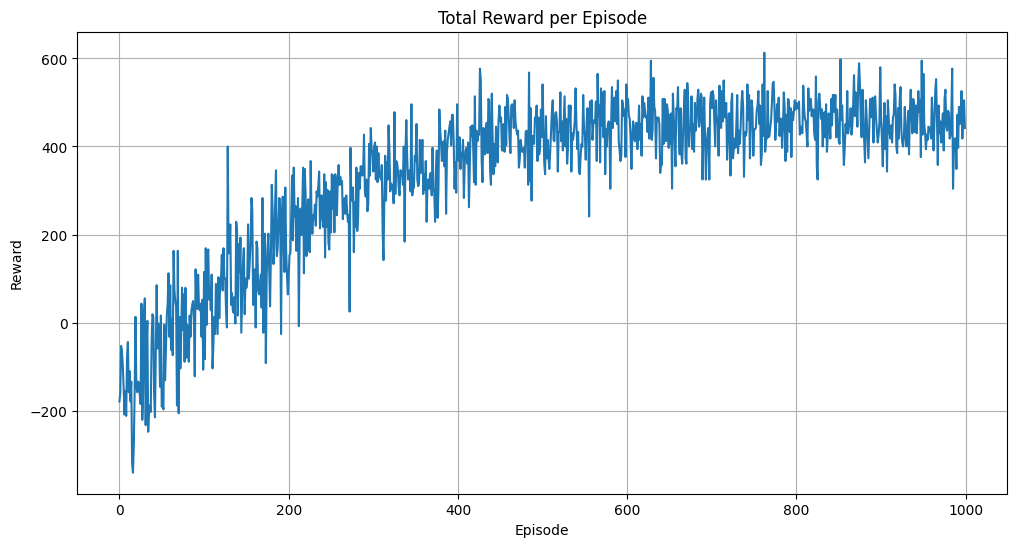

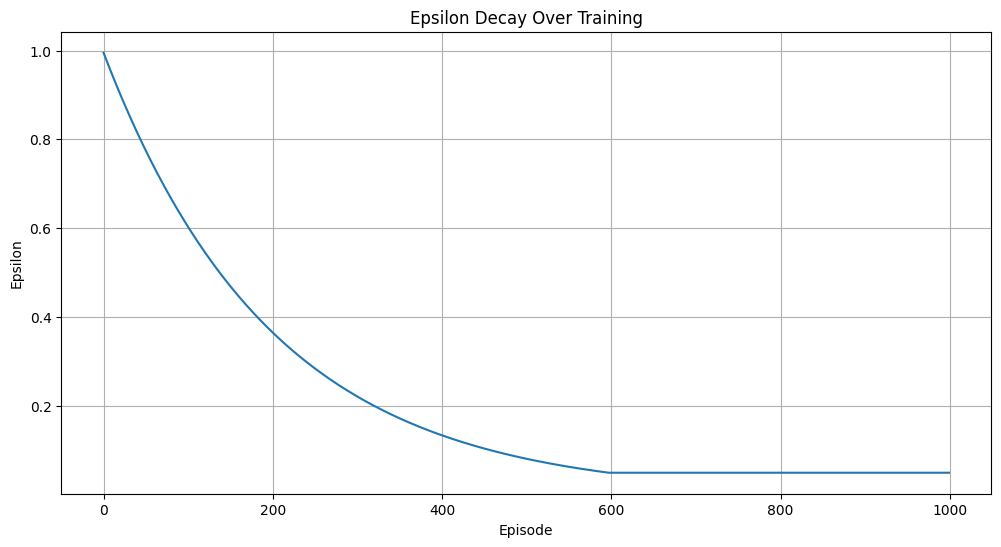

In [27]:
# Reward plot
plt.figure(figsize=(12, 6))
plt.plot(total_rewards_per_episode)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()

# Epsilon plot
plt.figure(figsize=(12, 6))
plt.plot(epsilons)
plt.title('Epsilon Decay Over Training')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()


Evaluation using test data

In [28]:
# Download Test Set
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt

# Preprocess Test Set
test_data = pd.read_csv('KDDTest+.txt', names=columns)
test_data.drop('difficulty', axis=1, inplace=True)
a = test_data

for col in ['protocol_type', 'service', 'flag']:
    test_data[col] = LabelEncoder().fit_transform(test_data[col])

X_test = test_data.drop('label', axis=1)
y_test = test_data['label']
y_test = y_test.apply(lambda x: 0 if x == 'normal' else 1)
X_test = scaler.transform(X_test)

class TestEnv(gym.Env):
    def __init__(self, X_data, y_data):
        super(TestEnv, self).__init__()
        self.X = X_data
        self.y = y_data
        self.n_samples = X_data.shape[0]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(5)
        self.current_idx = 0

    def reset(self):
        self.current_idx = 0
        return self.X[self.current_idx]

    def step(self, action):
        is_attack = self.y[self.current_idx]
        reward = 0
        correct = False
        false_positive = False
        false_negative = False

        if is_attack:
            if action in [1, 2, 3]:
                reward = 10
                correct = True
            else:
                reward = -10
                false_negative = True
        else:
            if action == 0:
                reward = 1
                correct = True
            else:
                reward = -2
                false_positive = True

        self.current_idx += 1
        done = self.current_idx >= self.n_samples
        next_state = None if done else self.X[self.current_idx]

        return next_state, reward, done, {
            'correct': correct,
            'false_positive': false_positive,
            'false_negative': false_negative,
            'is_attack': bool(is_attack)
        }

# Evaluate
test_env = TestEnv(X_test, y_test)

total_correct = 0
total_samples = 0
false_positives = 0
false_negatives = 0
total_attacks = 0
total_normals = 0

state = test_env.reset()
done = False

while not done:
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = agent(state_tensor)
        action = q_values.argmax().item()

    next_state, reward, done, info = test_env.step(action)

    total_samples += 1
    if info['correct']:
        total_correct += 1
    if info['false_positive']:
        false_positives += 1
    if info['false_negative']:
        false_negatives += 1
    if info['is_attack']:
        total_attacks += 1
    else:
        total_normals += 1

    state = next_state

# Metrics
accuracy = total_correct / total_samples
fpr = false_positives / total_normals if total_normals else 0
fnr = false_negatives / total_attacks if total_attacks else 0

print("\n=== Test Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print("===============================")


--2025-05-05 02:38:31--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3441513 (3.3M) [text/plain]
Saving to: ‘KDDTest+.txt.2’

KDDTest+.txt.2      100%[===================>]   3.28M  --.-KB/s    in 0.08s   

2025-05-05 02:38:31 (41.7 MB/s) - ‘KDDTest+.txt.2’ saved [3441513/3441513]


=== Test Evaluation Metrics ===
Accuracy: 0.8687
False Positive Rate (FPR): 0.0961
False Negative Rate (FNR): 0.1580


Save the trained DQN model to disk

In [29]:
# Save model
torch.save(agent.state_dict(), "dqn_intrusion_detector.pt")
print("Model saved successfully as dqn_intrusion_detector.pt!")


Model saved successfully as dqn_intrusion_detector.pt!


Load the saved model weights

In [30]:
# To load model later
agent.load_state_dict(torch.load("dqn_intrusion_detector.pt"))
agent.eval()  # set to evaluation mode


DQNAgent(
  (fc1): Linear(in_features=41, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)